# Load data

In [1]:
from collections import namedtuple
Deletion = namedtuple('Deletion', ['family', 'chrom', 
                                   'start_pos', 'end_pos', 'start_index', 'end_index', 'length',
                                   'inheritance_state', 'individuals',
                                   'doubledel', 'singledel', 'nodel',
                                   'singledel_maternal', 'singledel_paternal'])


In [2]:
ped_file = '160826.ped'
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            child_id_to_affected[child_id] = disease_status
            child_id_to_sex[child_id] = sex

In [843]:
chrom = '22'

In [844]:
# Pull cytogenetic coordinates
with open('cytoBand.txt', 'r') as f:
    xticks, xticklabels = [], []
    for line in f:
        pieces = line.strip().split()
        if pieces[0] == 'chr%s' % chrom:
            xticks.append(int(pieces[1]))
            xticklabels.append(pieces[3])

In [856]:
from collections import defaultdict

phase_dir = 'sherlock_phased'

# load deletions from all chromosomes
deletions = []
family_to_individuals = dict()
family_to_indices = dict()

fams = set()
for j in range(3, 7):
    with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            family_to_individuals[family_key] = pieces[1:(1+j)]
            family_to_indices[family_key] = [int(x) for x in pieces[(1+j):]]
            fams.add(family_key)
                
    # load deletions
    with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            inheritance_state = [int(x) for x in pieces[2:(2+(j*2))]]
            start_pos, end_pos, start_index, end_index = [int(x) for x in pieces[(2+(j*2)):(6+(j*2))]]
            length = end_pos - start_pos + 1
            individuals = family_to_individuals[family_key]
                
            doubledel, singledel, nodel = [], [], []
            singledel_mat, singledel_pat = [], []
                        
            # children
            for k, child_id in enumerate(individuals[2:]):
                mat, pat = inheritance_state[(4+(2*k)):(6+(2*k))]
                    
                if inheritance_state[mat] == 1 and inheritance_state[2+pat] == 1:
                    doubledel.append(child_id)
                elif inheritance_state[mat] == 1:
                    singledel.append(child_id)
                    singledel_mat.append(child_id)
                elif inheritance_state[2+pat] == 1:
                    singledel.append(child_id)
                    singledel_pat.append(child_id)
                else:
                    nodel.append(child_id)
                    
            deletions.append(Deletion(family_key, chrom,
                                          start_pos, end_pos, start_index, end_index, length,
                                          inheritance_state, individuals,
                                          doubledel, singledel, nodel,
                                          singledel_mat, singledel_pat))
                
print(chrom, 'Num fams', len(fams))
                    
print('deletions', len(deletions), 
      'maternal', sum([sum(x.inheritance_state[:2]) for x in deletions]), 
      'paternal', sum([sum(x.inheritance_state[2:4]) for x in deletions]))



22 Num fams 862
deletions 288712 maternal 289339 paternal 294796


In [857]:
print('Maternal inheritance rate', sum([len(x.singledel_maternal)+len(x.doubledel) for x in deletions if sum(x.inheritance_state[:2]) == 1])/sum([len(x.individuals)-2 for x in deletions if sum(x.inheritance_state[:2]) == 1]))
print('Paternal inheritance rate', sum([len(x.singledel_paternal)+len(x.doubledel) for x in deletions if sum(x.inheritance_state[2:4]) == 1])/sum([len(x.individuals)-2 for x in deletions if sum(x.inheritance_state[2:4]) == 1]))



Maternal inheritance rate 0.5162474166827331
Paternal inheritance rate 0.5158542842483325


# Analyze relationship between deletions and disease
We're going to look at both deletion status (DEL) as well as deletion transmission disequilibrium (TDT) and parental differences (PAR) as a baseline.

In [858]:
max_index = max([d.end_index for d in deletions])
snp_positions = np.zeros((max_index+1,))
        
# Create contingency tables for each comparison
del_conting_t = np.zeros((max_index+1, 3, 2), dtype=int)
tdt_conting_t = np.zeros((max_index+1, 2, 2), dtype=int)
par_conting_t = np.zeros((max_index+1, 3, 2), dtype=int)
    
for d in deletions:
    del_conting_t[d.start_index:(d.end_index+1), 0, 0] += len([x for x in d.doubledel if child_id_to_affected[x] == '2'])
    del_conting_t[d.start_index:(d.end_index+1), 0, 1] += len([x for x in d.doubledel if child_id_to_affected[x] != '2'])
    del_conting_t[d.start_index:(d.end_index+1), 1, 0] += len([x for x in d.singledel if child_id_to_affected[x] == '2'])
    del_conting_t[d.start_index:(d.end_index+1), 1, 1] += len([x for x in d.singledel if child_id_to_affected[x] != '2'])
    del_conting_t[d.start_index:(d.end_index+1), 2, 0] += len([x for x in d.nodel if child_id_to_affected[x] == '2'])
    del_conting_t[d.start_index:(d.end_index+1), 2, 1] += len([x for x in d.nodel if child_id_to_affected[x] != '2'])

    par_conting_t[d.start_index:(d.end_index+1), 2-sum(d.inheritance_state[:2]), 0] += 1
    par_conting_t[d.start_index:(d.end_index+1), 2-sum(d.inheritance_state[2:4]), 1] += 1
    
    if sum(d.inheritance_state[:2]) == 1:
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 0] += len([x for x in d.doubledel if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 0] += len([x for x in d.singledel_maternal if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 1] += len([x for x in d.doubledel if child_id_to_affected[x] != '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 1] += len([x for x in d.singledel_maternal if child_id_to_affected[x] != '2'])
        
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 0] += len([x for x in d.nodel if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 0] += len([x for x in d.singledel_paternal if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 1] += len([x for x in d.nodel if child_id_to_affected[x] != '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 1] += len([x for x in d.singledel_paternal if child_id_to_affected[x] != '2'])
        
    if sum(d.inheritance_state[2:4]) == 1:
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 0] += len([x for x in d.doubledel if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 0] += len([x for x in d.singledel_paternal if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 1] += len([x for x in d.doubledel if child_id_to_affected[x] != '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 1] += len([x for x in d.singledel_paternal if child_id_to_affected[x] != '2'])

        tdt_conting_t[d.start_index:(d.end_index+1), 1, 0] += len([x for x in d.nodel if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 0] += len([x for x in d.singledel_maternal if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 1] += len([x for x in d.nodel if child_id_to_affected[x] != '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 1] += len([x for x in d.singledel_maternal if child_id_to_affected[x] != '2'])
        
    snp_positions[d.start_index] = d.start_pos
    snp_positions[d.end_index] = d.end_pos
    
total_affected = sum([len([x for x in individuals[2:] if child_id_to_affected[x] == '2']) for individuals in family_to_individuals.values()])
total_unaffected = sum([len([x for x in individuals[2:] if child_id_to_affected[x] != '2']) for individuals in family_to_individuals.values()])
print('total affected', total_affected, 'total_unaffected', total_unaffected)

total_families = len(family_to_individuals)
print('total families', total_families)


total affected 1722 total_unaffected 379
total families 862


In [859]:
# calculate pvalues for every point
del_pvalues = np.ones((max_index+1,))
tdt_pvalues = np.ones((max_index+1,))
par_pvalues = np.ones((max_index+1,))

prev_i = 0
indices = np.where(snp_positions>0)[0]
for i in indices:
    # DEL
    dc = del_conting_t[i, :, :]
    dc = dc[np.ix_(np.sum(dc, axis=1)>0, np.sum(dc, axis=0)>0)]
    
    if dc.shape[0] > 1 and dc.shape[1] > 1:
        del_pvalue = chi2_contingency(dc, correction=False)[1]
    else:
        del_pvalue = 1
        
    del_pvalues[prev_i:i] = del_pvalue
    if del_pvalue <= 0.01/indices.shape[0]:
        print('DEL', del_pvalue, prev_i, i, int(snp_positions[prev_i]), int(snp_positions[i]))
        
    # TDT
    tc = tdt_conting_t[i, :, :]
    tc = tc[np.ix_(np.sum(tc, axis=1)>0, np.sum(tc, axis=0)>0)]
    
    if tc.shape[0] > 1 and tc.shape[1] > 1:
        tdt_pvalue = chi2_contingency(tc, correction=False)[1]
    else:
        tdt_pvalue = 1
        
    tdt_pvalues[prev_i:i] = tdt_pvalue
    if tdt_pvalue <= 0.01/indices.shape[0]:
        print('TDT', tdt_pvalue, prev_i, i, int(snp_positions[prev_i]), int(snp_positions[i]))

    # PAR
    pc = par_conting_t[i, :, :]
    pc = pc[np.ix_(np.sum(pc, axis=1)>0, np.sum(pc, axis=0)>0)]
    
    if pc.shape[0] > 1 and pc.shape[1] > 1:
        par_pvalue = chi2_contingency(pc, correction=False)[1]
    else:
        par_pvalue = 1
        
    par_pvalues[prev_i:i] = par_pvalue
    if par_pvalue <= 0.01/indices.shape[0]:
        print('PAR', par_pvalue, prev_i, i, int(snp_positions[prev_i]), int(snp_positions[i]))

    prev_i = i

PAR 5.77476980545e-09 96300 96301 18686208 18686212
PAR 1.18971181139e-20 96301 96302 18686212 18686213
PAR 1.18971181139e-20 96302 96305 18686213 18686226
PAR 5.59829268493e-18 96305 96307 18686226 18686230
PAR 5.39183330159e-17 96307 96314 18686230 18686260
DEL 1.94215914249e-07 96314 96315 18686260 18686264
PAR 9.65563441556e-17 96314 96315 18686260 18686264
DEL 1.94215914249e-07 96315 96322 18686264 18686287
PAR 9.65563441556e-17 96315 96322 18686264 18686287
DEL 2.55285714236e-07 96322 96323 18686287 18686295
PAR 1.0888510432e-17 96322 96323 18686287 18686295
PAR 1.84785016286e-17 96323 96325 18686295 18686298
PAR 8.85876649663e-20 96325 96326 18686298 18686315
PAR 7.52950376992e-20 96326 96327 18686315 18686323
PAR 1.30519106058e-19 96327 96328 18686323 18686336
PAR 4.01025447403e-20 96328 96329 18686336 18686337
PAR 6.97670904644e-20 96329 96330 18686337 18686338
PAR 6.97670904644e-20 96330 96331 18686338 18686341
PAR 3.06258679773e-20 96331 96332 18686341 18686342
PAR 7.7278787

PAR 1.77627681731e-101 97187 97188 18718710 18718712
PAR 4.62520921692e-105 97188 97189 18718712 18718715
PAR 3.07838888625e-107 97189 97190 18718715 18718722
PAR 5.73189653226e-108 97190 97191 18718722 18718724
PAR 1.9568347926e-109 97191 97192 18718724 18718727
PAR 2.53819178953e-111 97192 97193 18718727 18718731
PAR 1.1872731774e-111 97193 97194 18718731 18718732
PAR 2.20682937684e-112 97194 97195 18718732 18718735
PAR 4.66026898902e-123 97195 97196 18718735 18718740
PAR 1.89822455794e-123 97196 97197 18718740 18718744
PAR 7.72091782002e-124 97197 97198 18718744 18718746
PAR 5.15141974638e-125 97198 97199 18718746 18718751
PAR 8.50583001121e-126 97199 97200 18718751 18718753
PAR 8.50583001121e-126 97200 97201 18718753 18718756
PAR 3.43018122409e-126 97201 97202 18718756 18718758
PAR 5.55443539072e-127 97202 97203 18718758 18718765
PAR 8.94229663833e-128 97203 97204 18718765 18718770
PAR 2.27760594492e-129 97204 97205 18718770 18718773
PAR 1.41442631946e-130 97205 97206 18718773 1871

PAR 1.54852633572e-197 104936 104938 18881837 18881845
PAR 4.31509445804e-204 104938 104939 18881845 18881848
PAR 1.34296652389e-204 104939 104940 18881848 18881855
PAR 1.68000972171e-209 104940 104941 18881855 18881856
PAR 2.94934542544e-215 104941 104942 18881856 18881870
PAR 2.06085190405e-216 104942 104943 18881870 18881878
PAR 1.47874546871e-222 104943 104944 18881878 18881883
PAR 2.42561598024e-222 104944 104945 18881883 18881884
PAR 5.86105992057e-229 104945 104947 18881884 18881895
PAR 1.62815566606e-229 104947 104951 18881895 18881912
PAR 9.24672814136e-232 104951 104952 18881912 18881916
PAR 9.24672814136e-232 104952 104953 18881916 18881917
PAR 2.37552025417e-231 104953 104954 18881917 18881918
PAR 2.51459823652e-231 104954 104956 18881918 18881928
PAR 6.49021404219e-232 104956 104957 18881928 18881932
PAR 9.41300358937e-234 104957 104958 18881932 18881935
PAR 1.40218179272e-234 104958 104960 18881935 18881964
PAR 1.40218179272e-234 104960 104961 18881964 18881965
PAR 3.4952

PAR 8.92758365374e-12 153114 153115 20659409 20659410
PAR 2.65076846042e-11 153115 153116 20659410 20659428
PAR 6.74272550175e-13 153116 153117 20659428 20659461
PAR 8.72329147128e-12 153117 153118 20659461 20659496
PAR 1.70305979555e-12 153118 153119 20659496 20659497
PAR 5.60098242886e-13 153119 153120 20659497 20659501
PAR 1.77438556977e-12 153120 153121 20659501 20659506
PAR 4.32262136094e-16 153121 153122 20659506 20659524
PAR 9.95593573672e-17 153122 153123 20659524 20659533
PAR 9.74809831728e-17 153123 153124 20659533 20659544
PAR 1.87701083922e-16 153124 153125 20659544 20659557
PAR 1.23729367427e-16 153125 153126 20659557 20659559
PAR 1.2428140095e-16 153126 153127 20659559 20659565
PAR 1.27321634342e-16 153127 153128 20659565 20659567
PAR 3.04998299925e-16 153128 153130 20659567 20659575
PAR 3.97850847164e-16 153130 153131 20659575 20659583
PAR 7.8665465514e-16 153131 153132 20659583 20659593
PAR 8.00380783961e-16 153132 153133 20659593 20659596
PAR 7.9243010747e-16 153133 15

PAR 2.90375312782e-25 478701 478702 32542625 32542646
PAR 8.87136542758e-18 478702 478703 32542646 32542647


In [869]:
print(del_conting_t[96319, :, :])

[[1585  316]
 [ 137   63]
 [   0    0]]


cutoff 1
num peaks 405


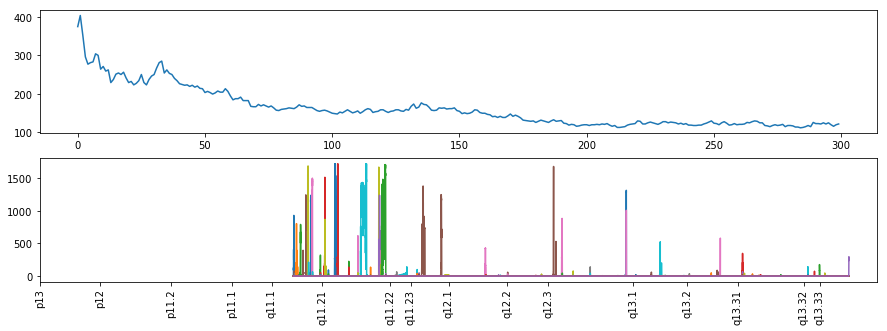

In [860]:
# Identify peaks from PAR
num_people = np.sum(par_conting_t[:, 0:2, :], axis=(1, 2))

# choose cutoff
num_peaks_by_cutoff = [np.where((num_people[:-1] <= x) & (num_people[1:] > x))[0].shape[0] for x in xs]
cutoff = max(list(range(300)), key=lambda i: num_peaks_by_cutoff[i])
print('cutoff %d' % cutoff)
    
# define peaks
peak_start_indices = np.where((num_people[:-1] <= cutoff) & (num_people[1:] > cutoff))[0]
peak_end_indices = np.where((num_people[:-1] > cutoff) & (num_people[1:] <= cutoff))[0]
    
# fix first and last
if peak_start_indices[0] > peak_end_indices[0]:
    peak_start_indices = np.insert(peak_start_indices, 0, 0)
if peak_start_indices.shape[0] != peak_end_indices.shape[0]:
    peak_end_indices = np.insert(peak_end_indices, peak_end_indices.shape[0], max_index)
num_peaks = peak_start_indices.shape[0]
print('num peaks %d' % num_peaks)

peaks = list(zip(peak_start_indices, peak_end_indices))

# Take a look
plt.figure(figsize=(15, 5))
plt.subplot(2, 1, 1)
plt.plot(num_peaks_by_cutoff)
plt.subplot(2, 1, 2)

for ps, pe in peaks:
    peak_positions = np.zeros((max_index+1,))
    peak_positions[(ps+1):(pe+1)] = num_people[(ps+1):(pe+1)]
    plt.plot(snp_positions[indices], peak_positions[indices])
    
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.show()

In [861]:
# map deletions to peaks
deletion_start_peak_start = np.searchsorted(peak_start_indices, [d.start_index for d in deletions])
deletion_end_peak_end = np.searchsorted(peak_end_indices, [d.end_index for d in deletions])

peak_to_deletions = defaultdict(list)
for d, ds, de in zip(deletions, deletion_start_peak_start, deletion_end_peak_end):
    for i in range(ds-1, min(de+1, peak_start_indices.shape[0])):
        ps, pe = peak_start_indices[i], peak_end_indices[i]
        if (d.start_index >= ps and d.start_index <= pe) or (d.end_index >= ps and d.end_index <= pe) or (d.start_index <= ps and d.end_index >= pe):
            peak_to_deletions[i].append(d)

In [862]:
from scipy.stats import chi2_contingency

# calculate pvalues for peaks
del_peak_pvalues = np.ones((max_index+1,))
tdt_peak_pvalues = np.ones((max_index+1,))
par_peak_pvalues = np.ones((max_index+1,))

for i in range(num_peaks):
    ds = peak_to_deletions[i]
    doubledel, singledel, nodel = set(), set(), set()
    mom_doubledel, mom_singledel, mom_nodel = set(), set(), set()
    dad_doubledel, dad_singledel, dad_nodel = set(), set(), set()
    trans, notrans = set(), set()
            
    for d in ds:
        # used for DEL
        doubledel.update(d.doubledel)
        singledel.update(d.singledel)
        nodel.update(d.nodel)
        
        
        # used for PAR
        if sum(d.inheritance_state[:2]) == 2:
            mom_doubledel.add(d.individuals[0])
        elif sum(d.inheritance_state[:2]) == 1:
            mom_singledel.add(d.individuals[0])
            
            # TDT
            trans.update(d.doubledel)
            trans.update(d.singledel_maternal)
            notrans.update(d.nodel)
            notrans.update(d.singledel_paternal)
        else:
            mom_nodel.add(d.individuals[0])
            
        if sum(d.inheritance_state[2:4]) == 2:
            dad_doubledel.add(d.individuals[1])
        elif sum(d.inheritance_state[2:4]) == 1:
            dad_singledel.add(d.individuals[1])
            
            # TDT
            trans.update(d.doubledel)
            trans.update(d.singledel_paternal)
            notrans.update(d.nodel)
            notrans.update(d.singledel_maternal)
        else:
            dad_nodel.add(d.individuals[1])
        
    # handle multiple deletions in the same family for this peak
    singledel = singledel - doubledel
    mom_singledel = mom_singledel - mom_doubledel
    dad_singledel = dad_singledel - dad_doubledel
    nodel = nodel - doubledel - singledel
    mom_nodel = mom_nodel - mom_doubledel - mom_singledel
    dad_nodel = dad_nodel - dad_doubledel - dad_singledel
    notrans = notrans - trans
      
    # DEL
    dc = np.asarray([[len([x for x in doubledel if child_id_to_affected[x] == '2']),
                   len([x for x in doubledel if child_id_to_affected[x] != '2'])], 
                   [len([x for x in singledel if child_id_to_affected[x] == '2']),
                   len([x for x in singledel if child_id_to_affected[x] != '2'])], 
                   [len([x for x in nodel if child_id_to_affected[x] == '2']),
                    len([x for x in nodel if child_id_to_affected[x] != '2'])]])
    dc = dc[np.ix_(np.sum(dc, axis=1)>0, np.sum(dc, axis=0)>0)]
    
    if dc.shape[0] > 1 and dc.shape[1] > 1:
        del_pvalue = chi2_contingency(dc, correction=False)[1]
    else:
        del_pvalue = 1
        
    del_peak_pvalues[(peak_start_indices[i]+1):(peak_end_indices[i]+1)] = del_pvalue
       
    # TDT
    tc = np.asarray([[len([x for x in trans if child_id_to_affected[x] == '2']),
                   len([x for x in trans if child_id_to_affected[x] != '2'])],
                  [len([x for x in notrans if child_id_to_affected[x] == '2']),
                   len([x for x in notrans if child_id_to_affected[x] != '2'])]])
    tc = tc[np.ix_(np.sum(tc, axis=1)>0, np.sum(tc, axis=0)>0)]
    
    if tc.shape[0] > 1 and tc.shape[1] > 1:
        tdt_pvalue = chi2_contingency(tc, correction=False)[1]
    else:
        tdt_pvalue = 1
        
    tdt_peak_pvalues[(peak_start_indices[i]+1):(peak_end_indices[i]+1)] = tdt_pvalue
        
    # PAR
    pc = np.asarray([[len(mom_doubledel), len(dad_doubledel)],
                  [len(mom_singledel), len(dad_singledel)],
                  [len(mom_nodel), len(dad_nodel)]])
    pc = pc[np.ix_(np.sum(pc, axis=1)>0, np.sum(pc, axis=0)>0)]
        
    if pc.shape[0] > 1 and pc.shape[1] > 1:
        par_pvalue = chi2_contingency(pc, correction=False)[1]
    else:
        par_pvalue = 1
    
    par_peak_pvalues[(peak_start_indices[i]+1):(peak_end_indices[i]+1)] = par_pvalue

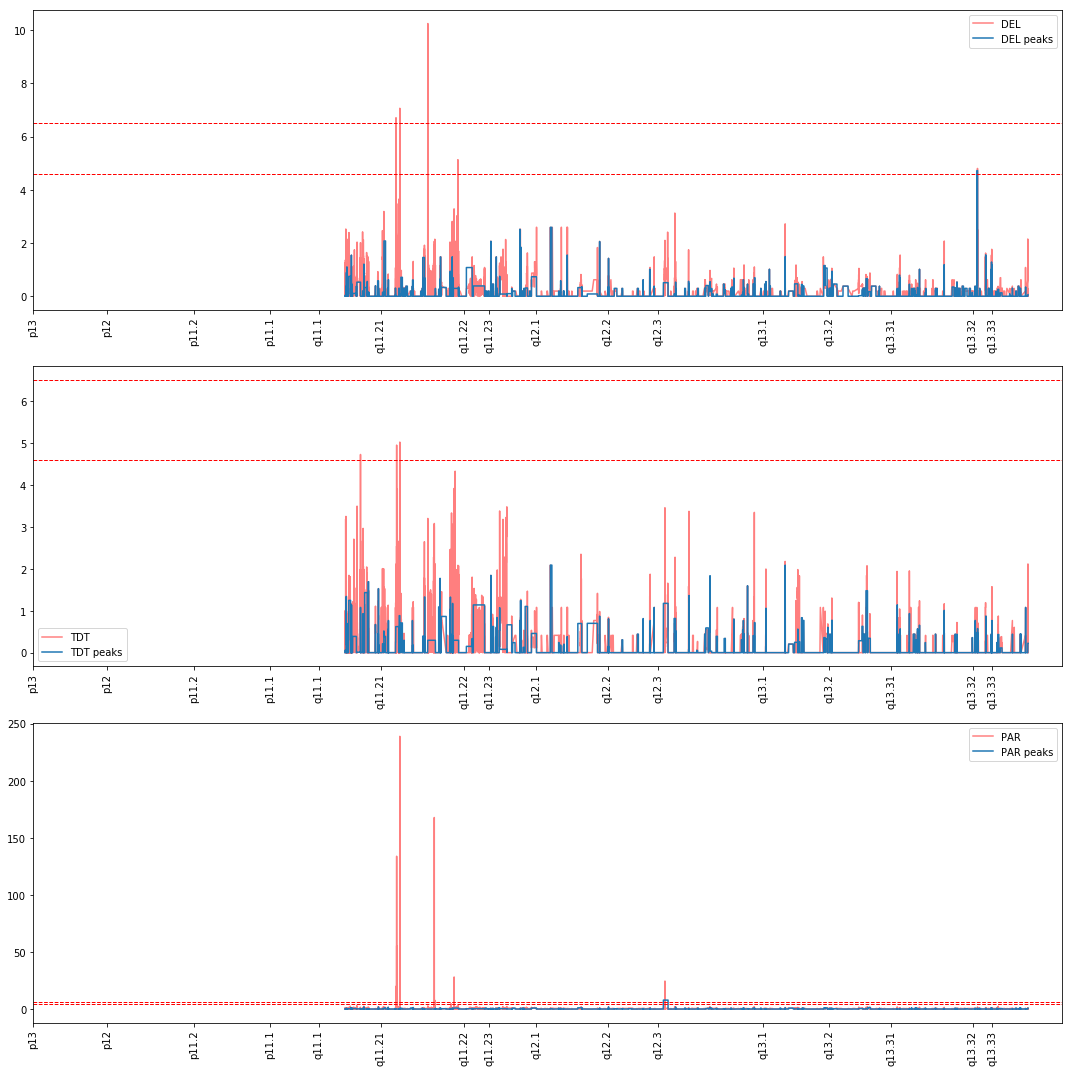

In [863]:
import numpy as np
from scipy.stats import binom

# plot pvalues
plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1)                                         
plt.plot(snp_positions[indices], -np.log10(del_pvalues[indices]), alpha=0.5, label='DEL', color='red')
plt.plot(snp_positions[indices], -np.log10(del_peak_pvalues[indices]), label='DEL peaks')

plt.xticks(xticks, xticklabels, rotation='vertical')
plt.axhline(y=-np.log10(0.01/indices.shape[0]), linewidth=1, linestyle='--', color='r')
plt.axhline(y=-np.log10(0.01/num_peaks), linewidth=1, linestyle='--', color='r')
plt.legend()


plt.subplot(3, 1, 2)            
plt.plot(snp_positions[indices], -np.log10(tdt_pvalues[indices]), alpha=0.5, label='TDT', color='red')
plt.plot(snp_positions[indices], -np.log10(tdt_peak_pvalues[indices]), label='TDT peaks')

plt.xticks(xticks, xticklabels, rotation='vertical')
plt.axhline(y=-np.log10(0.01/indices.shape[0]), linewidth=1, linestyle='--', color='r')
plt.axhline(y=-np.log10(0.01/num_peaks), linewidth=1, linestyle='--', color='r')
plt.legend()


plt.subplot(3, 1, 3) 
plt.plot(snp_positions[indices], -np.log10(par_pvalues[indices]), alpha=0.5, label='PAR', color='red')
plt.plot(snp_positions[indices], -np.log10(par_peak_pvalues[indices]), label='PAR peaks')

plt.xticks(xticks, xticklabels, rotation='vertical')
plt.axhline(y=-np.log10(0.01/indices.shape[0]), linewidth=1, linestyle='--', color='r')
plt.axhline(y=-np.log10(0.01/num_peaks), linewidth=1, linestyle='--', color='r')
plt.legend()


plt.tight_layout()
plt.show()

# Let's consider missing deletions
We won't be able to detect a deletion if it isn't inherited. So what fraction of the genome isn't inherited?

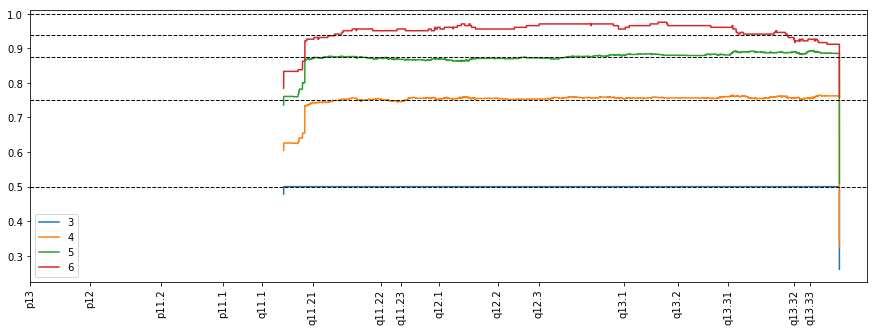

In [864]:
plt.figure(figsize=(15, 5))
inh_fs = [0]*8
for j in range(3, 7):
    inherited = np.zeros((max_index+1,), dtype=int)
    famkeys = set()

    prev_inh = None
    prev_end = -1
    with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            inheritance_state = [int(x) for x in pieces[2:(2+j*2)]]
            start_pos, end_pos, start_index, end_index = [int(x) for x in pieces[(2+j*2):(6+j*2)]]
                
            m1_inh, m2_inh, p1_inh, p2_inh = 0, 0, 0, 0
            for k, s in enumerate(inheritance_state[4:]):
                if k % 2 == 0:
                    m1_inh += (s==0)
                    m2_inh += (s==1)
                else:
                    p1_inh += (s==0)
                    p2_inh += (s==1)
                        
            if m1_inh:
                inherited[start_index:(end_index+1)] += 1
            if m2_inh:
                inherited[start_index:(end_index+1)] += 1
            if p1_inh:
                inherited[start_index:(end_index+1)] += 1
            if p2_inh:
                inherited[start_index:(end_index+1)] += 1
                
            if prev_inh is None or (prev_inh[0] and m1_inh):
                inherited[(prev_end+1):start_index] += 1
            if prev_inh is None or (prev_inh[1] and m2_inh):
                inherited[(prev_end+1):start_index] += 1
            if prev_inh is None or (prev_inh[2] and p1_inh):
                inherited[(prev_end+1):start_index] += 1
            if prev_inh is None or (prev_inh[3] and p2_inh):
                inherited[(prev_end+1):start_index] += 1
            prev_inh = (m1_inh, m2_inh, p1_inh, p2_inh)
            prev_end = end_index
            
            famkeys.add(family_key)

        inh_fs[j] = inherited/(4*len(famkeys))
        plt.plot(snp_positions[indices], inherited[indices]/(4*len(famkeys)), label=str(j))
        plt.xticks(xticks, xticklabels, rotation='vertical')

plt.axhline(y=1, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.5, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.75, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.875, linewidth=1, linestyle='--', color='black')
plt.axhline(y=0.9375, linewidth=1, linestyle='--', color='black')
plt.legend()
plt.show()

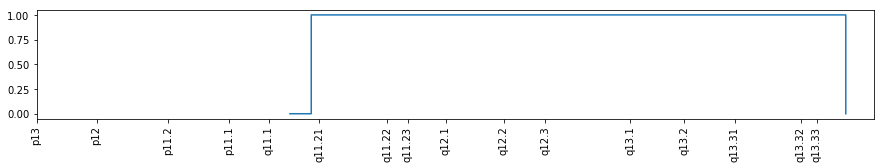

In [865]:
# only look at regions where inheritance rate is close to expected
ok_indices = (np.abs(inh_fs[3]-0.5) <= 0.05) & (np.abs(inh_fs[4]-0.75) <= 0.05) & (np.abs(inh_fs[5]-0.875) <= 0.05) & (np.abs(inh_fs[6]-0.9375) <= 0.05)

plt.figure(figsize=(15, 2))
plt.plot(snp_positions[indices], ok_indices[indices])
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.show()

In [871]:
print('Chrom', chrom)

# DEL hist
hit_start_indices = np.where((del_pvalues[:-1] > 0.01/indices.shape[0]) & (del_pvalues[1:] <= 0.01/indices.shape[0]))[0]
hit_end_indices = np.where((del_pvalues[:-1] <= 0.01/indices.shape[0]) & (del_pvalues[1:] > 0.01/indices.shape[0]))[0]

for hit_start, hit_end in zip(hit_start_indices, hit_end_indices):
    if (np.sum(ok_indices[(hit_start+1):(hit_end+1)]) == hit_end-hit_start) and np.all(par_pvalues[(hit_start+1):(hit_end+1)] > 0.01/indices.shape[0]):
        cyto = np.searchsorted(xticks, int(snp_positions[hit_start+1]))-1
        print('DEL', hit_start, hit_end, int(snp_positions[hit_start+1]), int(snp_positions[hit_end+1]), xticklabels[cyto])
        
hit_start_indices = np.where((del_peak_pvalues[:-1] > 0.01/num_peaks) & (del_peak_pvalues[1:] <= 0.01/num_peaks))[0]
hit_end_indices = np.where((del_peak_pvalues[:-1] <= 0.01/num_peaks) & (del_peak_pvalues[1:] > 0.01/num_peaks))[0]

for hit_start, hit_end in zip(hit_start_indices, hit_end_indices):
    if np.sum(ok_indices[(hit_start+1):(hit_end+1)]) == hit_end-hit_start and np.all(par_pvalues[(hit_start+1):(hit_end+1)] > 0.01/indices.shape[0]):
        cyto = np.searchsorted(xticks, int(snp_positions[hit_start+1]))-1
        print('DEL peak', hit_start, hit_end, int(snp_positions[hit_start+1]), int(snp_positions[hit_end]), xticklabels[cyto])
        
# TDT hist
hit_start_indices = np.where((tdt_pvalues[:-1] > 0.01/indices.shape[0]) & (tdt_pvalues[1:] <= 0.01/indices.shape[0]))[0]
hit_end_indices = np.where((tdt_pvalues[:-1] <= 0.01/indices.shape[0]) & (tdt_pvalues[1:] > 0.01/indices.shape[0]))[0]

for hit_start, hit_end in zip(hit_start_indices, hit_end_indices):
    if np.sum(ok_indices[(hit_start+1):(hit_end+1)]) == hit_end-hit_start and np.all(par_pvalues[(hit_start+1):(hit_end+1)] > 0.01/indices.shape[0]):
        cyto = np.searchsorted(xticks, int(snp_positions[hit_start+1]))-1
        print('TDT', hit_start, hit_end, int(snp_positions[hit_start+1]), int(snp_positions[hit_end+1]), xticklabels[cyto])
        
hit_start_indices = np.where((tdt_peak_pvalues[:-1] > 0.01/num_peaks) & (tdt_peak_pvalues[1:] <= 0.01/num_peaks))[0]
hit_end_indices = np.where((tdt_peak_pvalues[:-1] <= 0.01/num_peaks) & (tdt_peak_pvalues[1:] > 0.01/num_peaks))[0]

for hit_start, hit_end in zip(hit_start_indices, hit_end_indices):
    if np.sum(ok_indices[(hit_start+1):(hit_end+1)]) == hit_end-hit_start and np.all(par_pvalues[(hit_start+1):(hit_end+1)] > 0.01/indices.shape[0]):
        cyto = np.searchsorted(xticks, int(snp_positions[hit_start+1]))-1
        print('TDT peak', hit_start, hit_end, int(snp_positions[hit_start+1]), int(snp_positions[hit_end]), xticklabels[cyto])
        
# PAR hist
#hit_start_indices = np.where((par_pvalues[:-1] > 0.01/indices.shape[0]) & (par_pvalues[1:] <= 0.01/indices.shape[0]))[0]
#hit_end_indices = np.where((par_pvalues[:-1] <= 0.01/indices.shape[0]) & (par_pvalues[1:] > 0.01/indices.shape[0]))[0]

#for hit_start, hit_end in zip(hit_start_indices, hit_end_indices):
#    if np.sum(ok_indices[(hit_start+1):(hit_end+1)]) == hit_end-hit_start:
#        cyto = np.searchsorted(xticks, int(snp_positions[hit_start+1]))-1
#        print('PAR', hit_start, hit_end, int(snp_positions[hit_start+1]), int(snp_positions[hit_end+1]), xticklabels[cyto])
        
#hit_start_indices = np.where((par_peak_pvalues[:-1] > 0.01/num_peaks) & (par_peak_pvalues[1:] <= 0.01/num_peaks))[0]
#hit_end_indices = np.where((par_peak_pvalues[:-1] <= 0.01/num_peaks) & (par_peak_pvalues[1:] > 0.01/num_peaks))[0]
#
#for hit_start, hit_end in zip(hit_start_indices, hit_end_indices):
#    if np.sum(ok_indices[(hit_start+1):(hit_end+1)]) == hit_end-hit_start:
#        cyto = np.searchsorted(xticks, int(snp_positions[hit_start+1]))-1
#        print('PAR peak', hit_start, hit_end, int(snp_positions[hit_start+1]), int(snp_positions[hit_end]), xticklabels[cyto])
           

Chrom 22
DEL 146122 146125 20324176 20324257 q11.21
DEL 146137 146168 20324546 20325125 q11.21
DEL peak 919033 920241 48609694 48648842 q13.32


# Check for outliers

outliers 0
[]


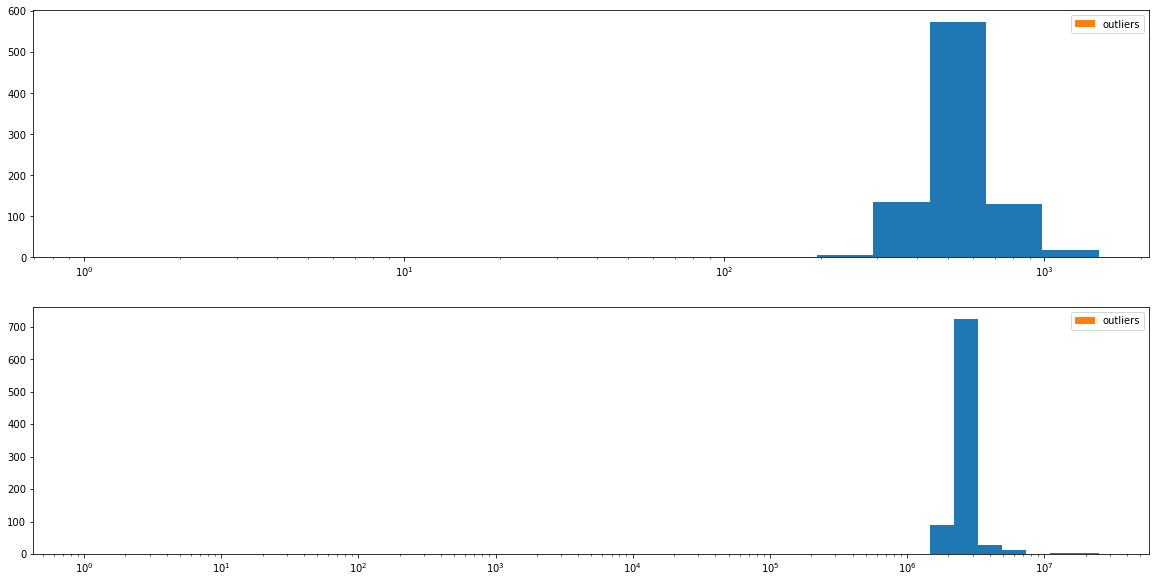

In [698]:
import math

from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import collections as mc

# deletions per family
plt.figure(figsize=(20, 10))

family_to_num_deletions = defaultdict(int)
family_to_nucleo_deleted = defaultdict(int)

for d in deletions:
    family_to_num_deletions[d.family] += 1
    family_to_nucleo_deleted[d.family] += d.length
    
outliers = [f for f in family_to_num_deletions.keys() if family_to_num_deletions[f] > 10000]
print('outliers', len(outliers))
print([(f, len(family_to_individuals[f])) for f in outliers])

base = 1.5

plt.subplot(2, 1, 1)
max_length = max(family_to_num_deletions.values()) 
bins = [pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)]
plt.hist([x for f, x in family_to_num_deletions.items() if f not in outliers], bins=bins)
plt.hist([x for f, x in family_to_num_deletions.items() if f in outliers], bins=bins, label='outliers')
plt.gca().set_xscale("log")
plt.legend()

plt.subplot(2, 1, 2)
max_length = max(family_to_nucleo_deleted.values()) 
bins = [pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)]
plt.hist([x for f, x in family_to_nucleo_deleted.items() if f not in outliers], bins=bins)
plt.hist([x for f, x in family_to_nucleo_deleted.items() if f in outliers], bins=bins, label='outliers')

plt.gca().set_xscale("log")
plt.legend()

#ax3 = plt.subplot(3, 1, 3)
#min_family = min(family_to_num_deletions.items(), key=lambda x:x[1])[0]
#max_family = max(family_to_num_deletions.items(), key=lambda x:x[1])[0]

#lines = [[(d.start_pos, 0), (d.end_pos, 0)] for d in deletions if d.family==min_family if d.chrom==4]
#lc = mc.LineCollection(lines, linewidths=12, colors='blue')
#ax3.add_collection(lc)
#ax3.autoscale()
#ax3.margins(0.1)
#lines = [[(d.start_pos, 0), (d.end_pos, 0)] for d in deletions if d.family==max_family if d.chrom==4]
#lc = mc.LineCollection(lines, linewidths=12, colors='red')
#ax3.add_collection(lc)
#ax3.autoscale()
#ax3.margins(0.1)

#plt.plot(sum([[d.start_pos, d.end_pos] for d in min_family_dels]), sum([[]]))
#plt.legend()
plt.show()

# Distribution of deletions

min length 1 max length 1125866


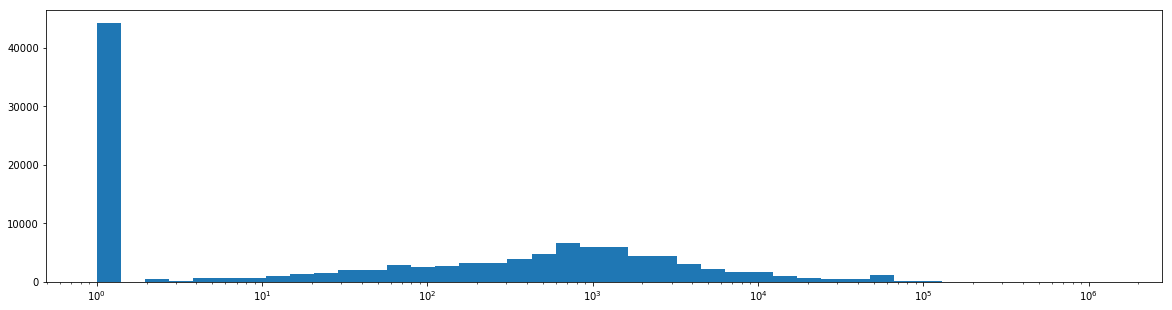

In [178]:
import math

# length of deletions
plt.figure(figsize=(20, 5))
base = 1.4
max_length = max([d.length for d in deletions]) 
min_length = min([d.length for d in deletions]) 
print('min length', min_length, 'max length', max_length)
plt.hist([d.length for d in deletions], bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)])
plt.gca().set_xscale("log")
plt.show()

min length 0 max length 30077


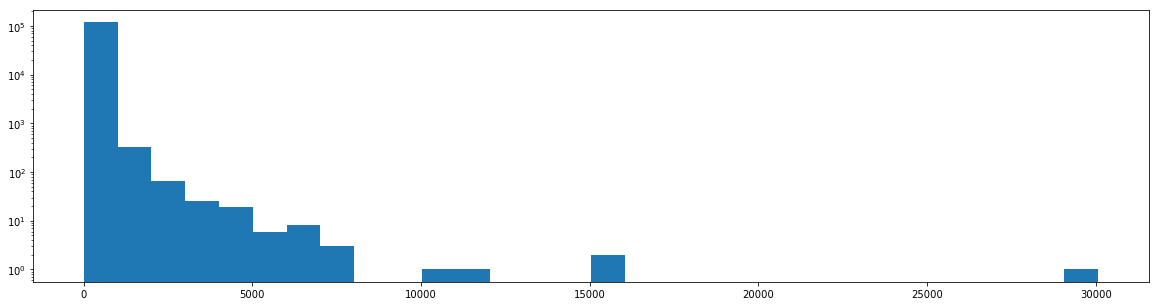

In [179]:
import math
import matplotlib.pyplot as plt

# length of deletions
plt.figure(figsize=(20, 5))
base = 1.4
max_length = max([d.end_index-d.start_index for d in deletions]) 
min_length = min([d.end_index-d.start_index for d in deletions]) 
print('min length', min_length, 'max length', max_length)
plt.hist([d.end_index-d.start_index for d in deletions], bins=30, log=True)#, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)])
#plt.gca().set_xscale("log")
plt.show()

# Investigate deletions in cytogenetic regions

In [519]:
from os import listdir
import gzip
import numpy as np
from scipy import sparse

# load genotypes
chrom = 22
gen_files = sorted([f for f in listdir('split_gen') if ('chr.%d' % chrom) in f and 'gen.npz' in f])
whole_chrom = sparse.hstack([sparse.load_npz('split_gen/%s' % gen_file) for gen_file in gen_files])
m, n = whole_chrom.shape
print(m, n)

# pull indices of snps
variant_file = 'split_gen/chr.%d.gen.variants.txt.gz' % chrom
snp_indices = []
snp_positions_all = []
with gzip.open(variant_file, 'rt') as f:
    for i, line in enumerate(f):
        pieces = line.strip().split('\t')
        if len(pieces[3]) == 1 and len(pieces[4]) == 1 and pieces[3] != '.' and pieces[4] != '.':
            snp_indices.append(i)
            snp_positions_all.append(int(pieces[1]))
snp_positions_all = np.asarray(snp_positions_all)

whole_chrom = whole_chrom[:, snp_indices]
m, n = whole_chrom.shape
print(m, n)

4610 1096535
4610 1004649


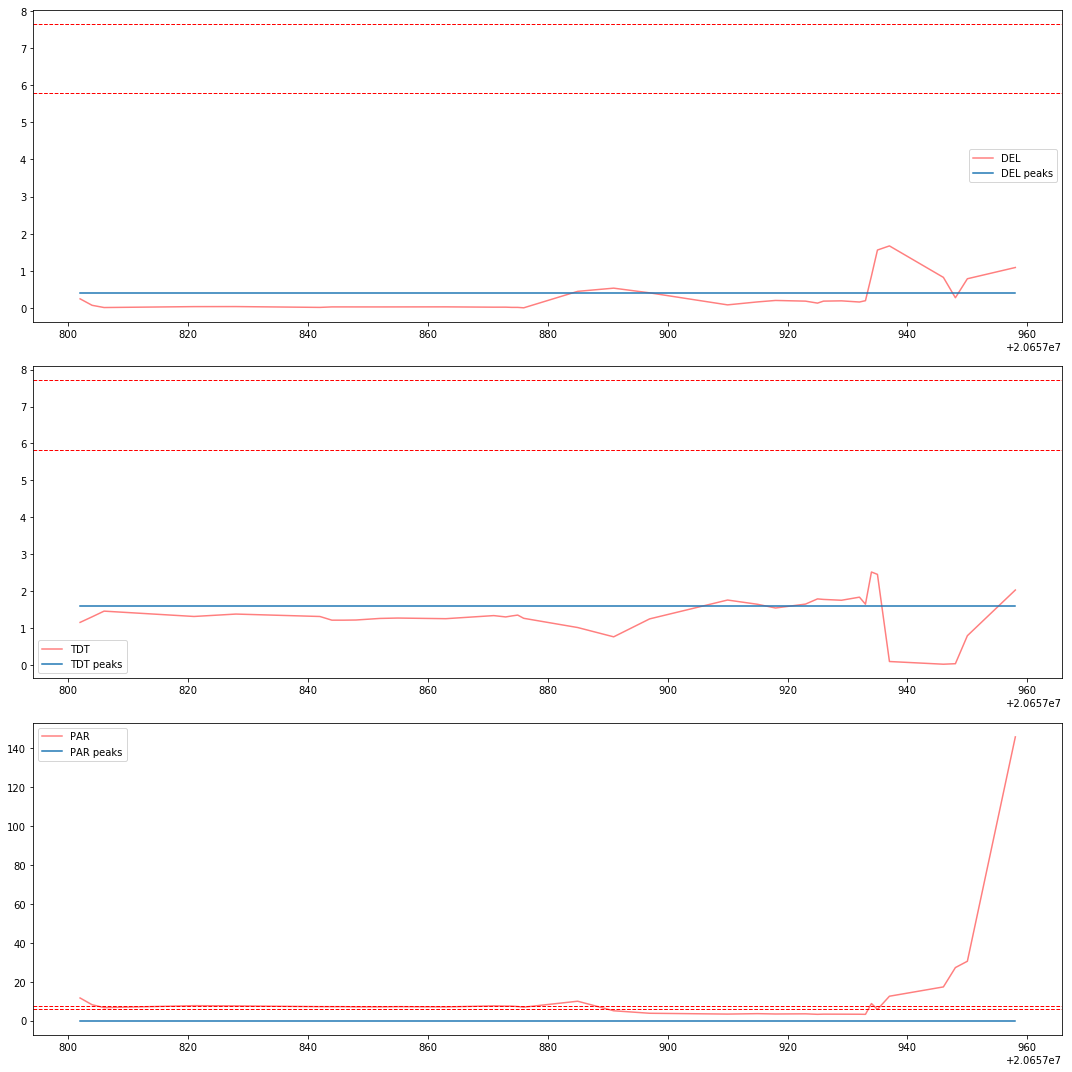

In [726]:
#start, end = 23500000, 25900000
#start, end = 24340000, 24400000

region = 'q12.3'
region_index = xticklabels.index(region)
#start, end = xticks[region_index], snp_positions[indices][-1] if region_index == len(xticks)-1 else xticks[region_index+1]
#start, end = 18718200, 18719700
#start, end = 18715000, 18723000
#start, end = 18878647, 18883675
start, end = 20657800, 20658000
#start, end = 20659158, 20659224

#start, end = 24340000, 24400000
region_indices = [i for i in indices if snp_positions[i]>= start and snp_positions[i] <= end]

#PAR 96907 96909 18717398.0 18717413.0
#PAR 97110 97113 18718215.0 18718224.0
#PAR 97125 97258 18718275.0 18719619.0
#PAR 97339 97348 18721132.0 18721167.0
#PAR 104573 104581 18878647.0 18878670.0
#PAR 104584 104586 18878679.0 18878681.0
#PAR 104631 104633 18879725.0 18879886.0
#PAR 104694 104797 18880169.0 18880670.0
#PAR 104798 104805 18880676.0 18880714.0
#PAR 104806 105050 18880721.0 18883675.0
#PAR 153030 153032 20657950.0 20658036.0
#PAR 153090 153092 20659158.0 20659224.0

# position of deletions
plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1) 
p_values = np.ones((max_index+1,))
p_values[del_num_people>0] = [trans_to_pvalue[tuple(np.reshape(del_conting_t[i, :, :], (6,)))][1] for i in np.where(del_num_people>0)[0]]
plt.plot(snp_positions[region_indices], -np.log10(p_values[region_indices]), alpha=0.5, label='DEL', color='red')
plt.plot(snp_positions[region_indices], -np.log10(del_peak_pvalues[region_indices]), label='DEL peaks')

plt.axhline(y=-np.log10(0.01/(num_del_changes*30)), linewidth=1, linestyle='--', color='r')
plt.axhline(y=-np.log10(0.01/(num_del_peaks*30)), linewidth=1, linestyle='--', color='r')

plt.legend()

plt.subplot(3, 1, 2)                                       
p_values = np.ones((max_index+1,))
p_values[tdt_num_people>0] = [trans_to_pvalue[tuple(np.reshape(tdt_conting_t[i, :, :], (4,)))][1] for i in np.where(tdt_num_people>0)[0]]
plt.plot(snp_positions[region_indices], -np.log10(p_values[region_indices]), alpha=0.5, label='TDT', color='red')
plt.plot(snp_positions[region_indices], -np.log10(tdt_peak_pvalues[region_indices]), label='TDT peaks')

plt.axhline(y=-np.log10(0.01/(num_tdt_changes*30)), linewidth=1, linestyle='--', color='r')
plt.axhline(y=-np.log10(0.01/(num_tdt_peaks*30)), linewidth=1, linestyle='--', color='r')

plt.legend()

plt.subplot(3, 1, 3) 
p_values = np.ones((max_index+1,))
p_values[par_num_people>0] = [trans_to_pvalue[tuple(np.reshape(par_conting_t[i, :, :], (6,)))][1] for i in np.where(par_num_people>0)[0]]
plt.plot(snp_positions[region_indices], -np.log10(p_values[region_indices]), alpha=0.5, label='PAR', color='red')
plt.plot(snp_positions[region_indices], -np.log10(par_peak_pvalues[region_indices]), label='PAR peaks')

plt.axhline(y=-np.log10(0.01/(num_par_changes*30)), linewidth=1, linestyle='--', color='r')
plt.axhline(y=-np.log10(0.01/(num_par_peaks*30)), linewidth=1, linestyle='--', color='r')
#plt.ylim([0, 10])
plt.legend()


plt.tight_layout()
plt.show()

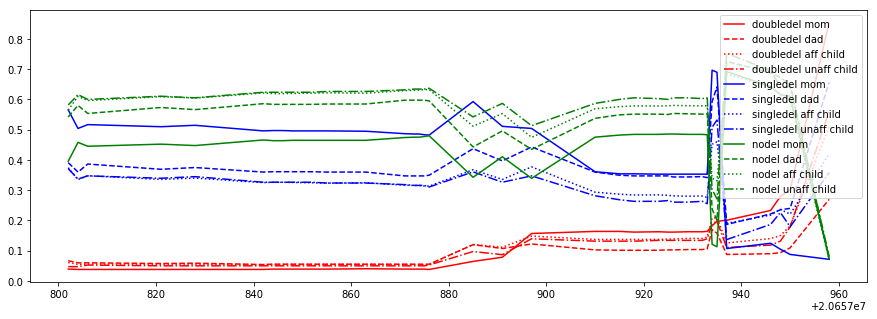

In [727]:
plt.figure(figsize=(15, 5))
plt.plot(snp_positions[region_indices], par_conting_t[region_indices, 0, 0]/total_families, label='doubledel mom', color='red')
plt.plot(snp_positions[region_indices], par_conting_t[region_indices, 0, 1]/total_families, label='doubledel dad', color='red', linestyle='--')
plt.plot(snp_positions[region_indices], del_conting_t[region_indices, 0, 0]/total_affected, label='doubledel aff child', color='red', linestyle=':')
plt.plot(snp_positions[region_indices], del_conting_t[region_indices, 0, 1]/total_unaffected, label='doubledel unaff child', color='red', linestyle='-.')

plt.plot(snp_positions[region_indices], par_conting_t[region_indices, 1, 0]/total_families, label='singledel mom', color='blue')
plt.plot(snp_positions[region_indices], par_conting_t[region_indices, 1, 1]/total_families, label='singledel dad', color='blue', linestyle='--')
plt.plot(snp_positions[region_indices], del_conting_t[region_indices, 1, 0]/total_affected, label='singledel aff child', color='blue', linestyle=':')
plt.plot(snp_positions[region_indices], del_conting_t[region_indices, 1, 1]/total_unaffected, label='singledel unaff child', color='blue', linestyle='-.')

plt.plot(snp_positions[region_indices], par_conting_t[region_indices, 2, 0]/total_families, label='nodel mom', color='green')
plt.plot(snp_positions[region_indices], par_conting_t[region_indices, 2, 1]/total_families, label='nodel dad', color='green', linestyle='--')
plt.plot(snp_positions[region_indices], del_conting_t[region_indices, 2, 0]/total_affected, label='nodel aff child', color='green', linestyle=':')
plt.plot(snp_positions[region_indices], del_conting_t[region_indices, 2, 1]/total_unaffected, label='nodel unaff child', color='green', linestyle='-.')

plt.legend()
plt.show()

1247


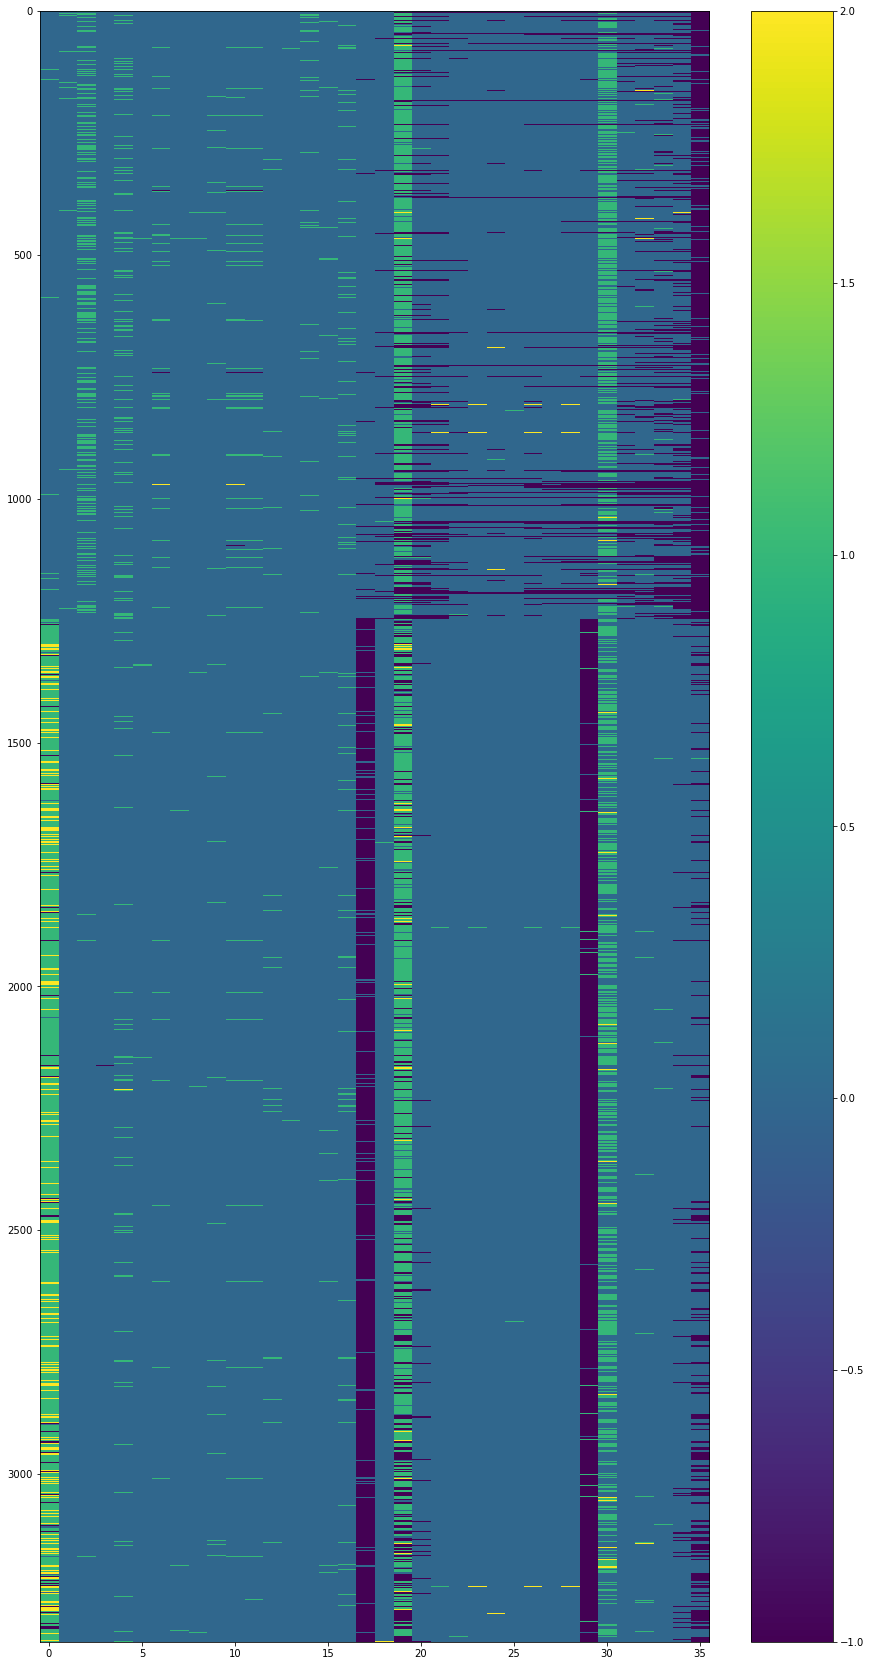

In [730]:
region = whole_chrom[:, (snp_positions>=start) & (snp_positions <= end)].A

plt.figure(figsize=(15, 30))
mom_indices = [x[0] for x in family_to_indices.values()]
plt.imshow(region[female_indices+male_indices, :], aspect='auto')
print(len(female_indices))
plt.colorbar()
plt.show()

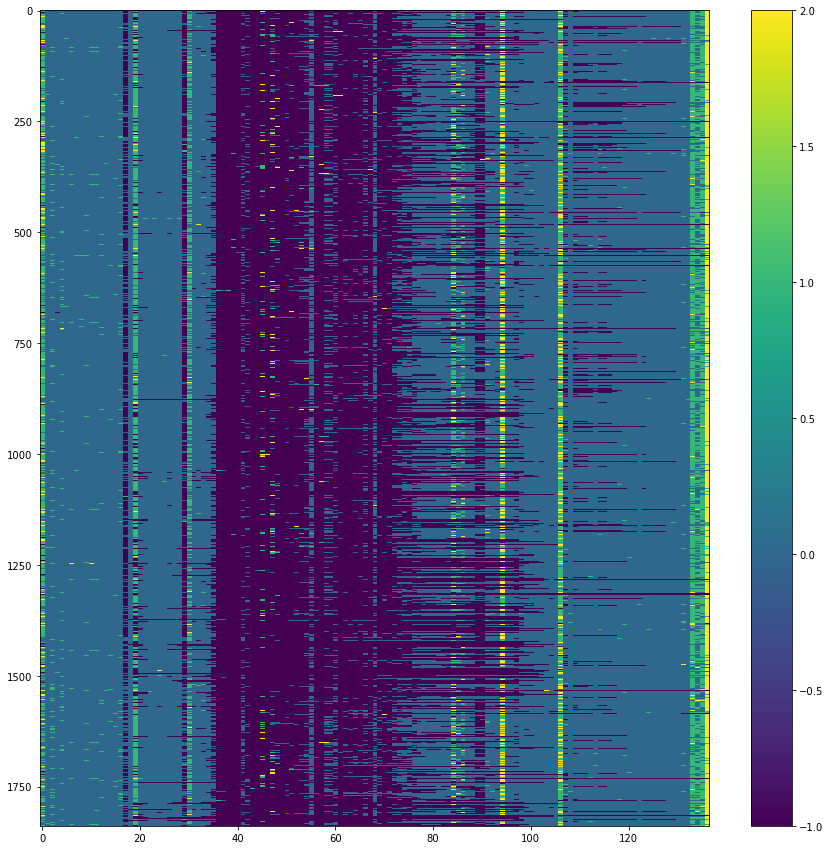

In [672]:
affected_child_indices, unaffected_child_indices = [], []
male_indices, female_indices = [], []

for fkey, findices in family_to_indices.items():
    individuals = family_to_individuals[fkey]
    for index, indid in zip(findices[2:], individuals[2:]):
        if child_id_to_affected[indid] == '2':
            affected_child_indices.append(index)
        else:
            unaffected_child_indices.append(index)
        
    for index, indid in zip(findices, individuals):
        if child_id_to_sex[indid] == '1':
            male_indices.append(index)
        else:
            female_indices.append(index)
            
plt.figure(figsize=(15, 15))
plt.imshow(region[affected_child_indices + unaffected_child_indices, :], aspect='auto')
plt.colorbar()
plt.show()

# Quick Missing Value Analysis

In [651]:
mom_missing = np.sum(whole_chrom[mom_indices, :]==-1, axis=0)
mom_het = np.sum(whole_chrom[mom_indices, :]==1, axis=0)
mom_homalt = np.sum(whole_chrom[mom_indices, :]==2, axis=0)

dad_missing = np.sum(whole_chrom[dad_indices, :]==-1, axis=0)
dad_het = np.sum(whole_chrom[dad_indices, :]==1, axis=0)
dad_homalt = np.sum(whole_chrom[dad_indices, :]==2, axis=0)

aff_missing = np.sum(whole_chrom[affected_child_indices, :]==-1, axis=0)
aff_het = np.sum(whole_chrom[affected_child_indices, :]==1, axis=0)
aff_homalt = np.sum(whole_chrom[affected_child_indices, :]==2, axis=0)

unaff_missing = np.sum(whole_chrom[unaffected_child_indices, :]==-1, axis=0)
unaff_het = np.sum(whole_chrom[unaffected_child_indices, :]==1, axis=0)
unaff_homalt = np.sum(whole_chrom[unaffected_child_indices, :]==2, axis=0)

In [673]:
male_missing = np.sum(whole_chrom[male_indices, :]==-1, axis=0)
male_het = np.sum(whole_chrom[male_indices, :]==1, axis=0)
male_homalt = np.sum(whole_chrom[male_indices, :]==2, axis=0)

female_missing = np.sum(whole_chrom[female_indices, :]==-1, axis=0)
female_het = np.sum(whole_chrom[female_indices, :]==1, axis=0)
female_homalt = np.sum(whole_chrom[female_indices, :]==2, axis=0)

total_male = len(male_indices)
total_female = len(female_indices)
print(len(female_child_indices), len(male_child_indices))

494 1345


In [636]:
trans_to_pvalue = dict()

mom_v_dad_missing = np.ones((whole_chrom.shape[1],))
mom_v_dad_gen = np.ones((whole_chrom.shape[1],))

num_tests = 0
for i in range(whole_chrom.shape[1]):
    t = (mom_missing[0, i], dad_missing[0, i], total_families-mom_missing[0, i], total_families-dad_missing[0, i])
    if mom_missing[0, i]>0 or dad_missing[0, i]>0:
        if t not in trans_to_pvalue:
            trans_to_pvalue[t] = chi2_contingency([[t[0], t[1]], [t[2], t[3]]])[1]
        mom_v_dad_missing[i] = trans_to_pvalue[t]
        num_tests += 1

print(-np.log10(0.01/num_tests))

num_tests = 0
for i in range(whole_chrom.shape[1]):
    t = (total_families-mom_missing[0, i]-mom_het[0, i]-mom_homalt[0, i], 
         total_families-dad_missing[0, i]-dad_het[0, i]-dad_homalt[0, i], 
         mom_het[0, i], dad_het[0, i], 
         mom_homalt[0, i], dad_homalt[0, i])
    
    cont = np.asarray([[t[0], t[1]], [t[2], t[3]], [t[4], t[5]]])
    cont = cont[np.sum(cont, axis=1)>0, :]
    if t not in trans_to_pvalue and cont.shape[0]>1 and cont.shape[1]>1:
        try:
            trans_to_pvalue[t] = chi2_contingency(cont)[1]
        except ValueError:
            print(t)
    if t in trans_to_pvalue:
        mom_v_dad_gen[i] = trans_to_pvalue[t]
        num_tests += 1
print(-np.log10(0.01/num_tests))


6.9810208381
(0, 26, 0, 1, 0, 0)
(0, 23, 0, 0, 0, 1)
(0, 28, 0, 0, 0, 27)
(0, 26, 0, 0, 0, 7)
(0, 23, 0, 1, 0, 0)
(0, 25, 0, 4, 0, 0)
(0, 23, 0, 2, 0, 0)
(0, 23, 0, 2, 0, 1)
7.91754961945


In [641]:
trans_to_pvalue = dict()

aff_v_unaff_missing = np.ones((whole_chrom.shape[1],))
aff_v_unaff_gen = np.ones((whole_chrom.shape[1],))

num_tests = 0
for i in range(whole_chrom.shape[1]):
    t = (aff_missing[0, i], unaff_missing[0, i], total_affected-aff_missing[0, i], total_unaffected-unaff_missing[0, i])
    cont = np.asarray([[t[0], t[1]], [t[2], t[3]]])
    cont = cont[np.sum(cont, axis=1)>0, :]
    if t not in trans_to_pvalue and cont.shape[0]>1 and cont.shape[1]>1:
        try:
            trans_to_pvalue[t] = chi2_contingency([[t[0], t[1]], [t[2], t[3]]])[1]
        except ValuError:
            print(t)
    if t in trans_to_pvalue:
        aff_v_unaff_missing[i] = trans_to_pvalue[t]
        num_tests += 1

print(-np.log10(0.01/num_tests))

num_tests = 0
for i in range(whole_chrom.shape[1]):
    t = (total_affected-aff_missing[0, i]-aff_het[0, i]-aff_homalt[0, i], 
         total_unaffected-unaff_missing[0, i]-unaff_het[0, i]-unaff_homalt[0, i], 
         aff_het[0, i], unaff_het[0, i], 
         aff_homalt[0, i], unaff_homalt[0, i])
    
    cont = np.asarray([[t[0], t[1]], [t[2], t[3]], [t[4], t[5]]])
    cont = cont[np.sum(cont, axis=1)>0, :]
    if t not in trans_to_pvalue and cont.shape[0]>1 and cont.shape[1]>1:
        try:
            trans_to_pvalue[t] = chi2_contingency(cont)[1]
        except ValueError:
            print(t)
    if t in trans_to_pvalue:
        aff_v_unaff_gen[i] = trans_to_pvalue[t]
        num_tests += 1
print(-np.log10(0.01/num_tests))


6.94297483243
(1, 0, 0, 0, 1, 0)
(1, 0, 0, 0, 1, 0)
(2, 0, 1, 0, 0, 0)
(2, 0, 1, 0, 0, 0)
(2, 0, 1, 0, 0, 0)
(1, 0, 2, 0, 0, 0)
(0, 0, 1, 0, 1, 0)
(2, 0, 0, 0, 3, 0)
(3, 0, 0, 0, 1, 0)
(1, 0, 0, 0, 2, 0)
(2, 0, 4, 0, 1, 0)
(2, 0, 3, 0, 1, 0)
(5, 0, 1, 0, 0, 0)
(9, 0, 1, 0, 0, 0)
(5, 0, 0, 0, 1, 0)
(2, 0, 1, 0, 0, 0)
(2, 0, 1, 0, 0, 0)
(7, 0, 0, 0, 3, 0)
(1, 0, 0, 0, 3, 0)
(1, 0, 2, 0, 3, 0)
(1, 0, 3, 0, 0, 0)
(1, 0, 1, 0, 0, 0)
7.87313393717


In [736]:
trans_to_pvalue = dict()

male_v_female_missing = np.ones((whole_chrom.shape[1],))
male_v_female_gen = np.ones((whole_chrom.shape[1],))

num_tests = 0
for i in range(whole_chrom.shape[1]):
    t = (male_missing[0, i], female_missing[0, i], total_male-male_missing[0, i], total_female-female_missing[0, i])
    cont = np.asarray([[t[0], t[1]], [t[2], t[3]]])
    cont = cont[np.sum(cont, axis=1)>0, :]
    if t not in trans_to_pvalue and cont.shape[0]>1 and cont.shape[1]>1:
        try:
            trans_to_pvalue[t] = chi2_contingency([[t[0], t[1]], [t[2], t[3]]])[1]
        except ValueError:
            print(t)
    if t in trans_to_pvalue:
        male_v_female_missing[i] = trans_to_pvalue[t]
        num_tests += 1

print(-np.log10(0.01/num_tests))

num_tests = 0
for i in range(whole_chrom.shape[1]):
    t = (total_male-male_missing[0, i]-male_het[0, i]-male_homalt[0, i], 
         total_female-female_missing[0, i]-female_het[0, i]-female_homalt[0, i], 
         male_het[0, i], female_het[0, i], 
         male_homalt[0, i], female_homalt[0, i],
         male_missing[0, i], female_missing[0, i])
    
    cont = np.asarray([[t[0], t[1]], [t[2], t[3]], [t[4], t[5]], [t[6], t[7]]])
    cont = cont[np.sum(cont, axis=1)>0, :]
    if t not in trans_to_pvalue and cont.shape[0]>1 and cont.shape[1]>1:
        try:
            trans_to_pvalue[t] = chi2_contingency(cont)[1]
        except ValueError:
            print(t)
    if t in trans_to_pvalue:
        male_v_female_gen[i] = trans_to_pvalue[t]
        num_tests += 1
print(-np.log10(0.01/num_tests))


7.02576040739
7.93619192366


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  
//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


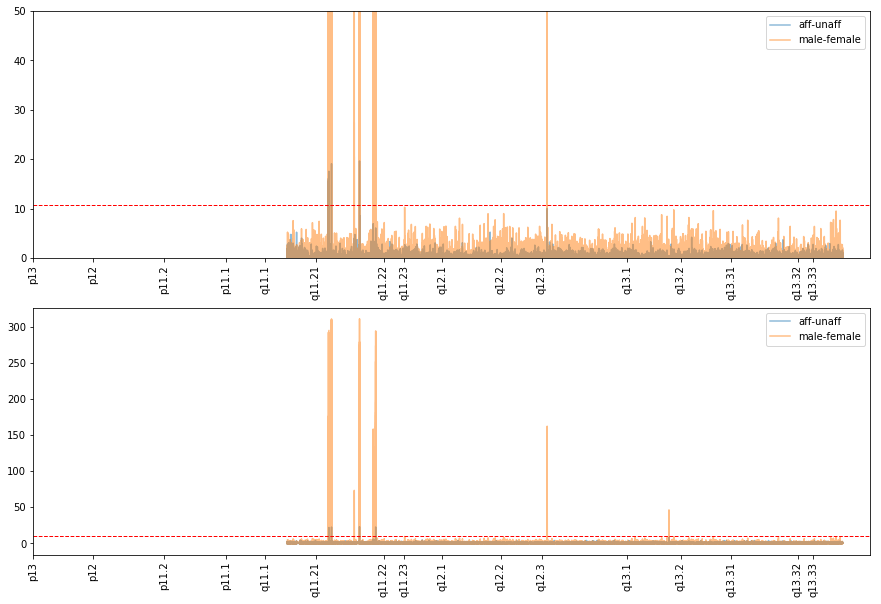

In [739]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
#plt.plot(snp_positions_all, -np.log10(mom_v_dad_missing), alpha=0.5, label='mom-dad')
plt.plot(snp_positions_all, -np.log10(aff_v_unaff_missing), alpha=0.5, label='aff-unaff')
plt.plot(snp_positions_all, -np.log10(male_v_female_missing), alpha=0.5, label='male-female')

plt.axhline(y=-np.log10(0.01/(num_tests*6*100)), linewidth=1, linestyle='--', color='r')
plt.ylim(0, 50)
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.legend()

plt.subplot(2, 1, 2)
#plt.plot(snp_positions_all, -np.log10(mom_v_dad_gen), alpha=0.5, label='mom-dad')
plt.plot(snp_positions_all, -np.log10(aff_v_unaff_gen), alpha=0.5, label='aff-unaff')
plt.plot(snp_positions_all, -np.log10(male_v_female_gen), alpha=0.5, label='male-female')

plt.axhline(y=-np.log10(0.01/(num_tests*6*100)), linewidth=1, linestyle='--', color='r')
#plt.ylim(0, 50)
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.legend()

plt.show()

In [781]:
is_sig = np.where(-np.log10(male_v_female_gen[1:])>=10)[0]
print(is_sig[:10])

[96294 96296 96301 96304 96308 96314 96316 96319 96321 96325]


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


In [ ]:
from os import listdir
import gzip
import numpy as np
from scipy import sparse

# load dp
chrom = 22
dp_files = sorted([f for f in listdir('split_dp') if ('chr.%d' % chrom) in f and 'dp.npz' in f])
whole_dp = sparse.hstack([sparse.load_npz('split_dp/%s' % dp_file) for dp_file in dp_files])
m, n = whole_chrom.shape
print(m, n)

# pull indices of snps
variant_file = 'split_dp/chr.%d.dp.variants.txt.gz' % chrom
snp_indices = []
snp_positions_all = []
with gzip.open(variant_file, 'rt') as f:
    for i, line in enumerate(f):
        pieces = line.strip().split('\t')
        if len(pieces[3]) == 1 and len(pieces[4]) == 1 and pieces[3] != '.' and pieces[4] != '.':
            snp_indices.append(i)
            snp_positions_all.append(int(pieces[1]))
snp_positions_all = np.asarray(snp_positions_all)

whole_dp = whole_dp[:, snp_indices].A
print(whole_chrom.shape, whole_dp.shape)

In [ ]:
whole_dp[whole_dp == 0] = 20

In [ ]:
region_dp = whole_dp[:, is_sig].A

plt.figure(figsize=(15, 20))
plt.subplot(2, 1, 1)
plt.imshow(whole_chrom[female_indices+male_indices, 96200:96500].A, aspect='auto')
plt.colorbar()
plt.subplot(2, 1, 2)
plt.imshow(whole_dp[female_indices+male_indices, 96200:96500].A, aspect='auto')
plt.colorbar()

plt.show()